# Title
Info

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
# sns.set(context='paper', style='white', font='CMU Serif', rc={'axes.labelpad':0, 'axes.linewidth': 0.5})
sns.set(context='paper', style='whitegrid', font='CMU Serif', rc={'axes.labelpad':0, 'axes.linewidth': 0.5})
sns.set_context("notebook", rc={"grid.linewidth": 0.5})

In [2]:
class Inputs():
    def __init__(self, deltaP, maxSamples, seed=0):
        self.deltaP = deltaP
        self.maxSamples = maxSamples
        self.winning = None
        self.pA = None
        self.pB = None
        self.dP_actual = None
        self.As = []
        self.Bs = []
        self.rng = np.random.RandomState(seed=seed)
    def set_AB(self):
        self.winning = "A" if self.rng.rand()<0.5 else "B"
        highs = np.arange(0.1+self.deltaP, 0.9, 0.1)
        high = highs[self.rng.randint(len(highs))]
        low = high - self.deltaP
        nUpWin = int(high*self.maxSamples)
        nUpLose = int(low*self.maxSamples)
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if self.winning=="A":
            self.As[:nUpWin] = 1
            self.As[nUpWin:] = -1
            self.Bs[:nUpLose] = 1
            self.Bs[nUpLose:] = -1
            self.pA = nUpWin / self.maxSamples
            self.pB = nUpLose / self.maxSamples
        else:
            self.Bs[:nUpWin] = 1
            self.Bs[nUpWin:] = -1
            self.As[:nUpLose] = 1
            self.As[nUpLose:] = -1
            self.pB = nUpWin / self.maxSamples
            self.pA = nUpLose / self.maxSamples
        self.rng.shuffle(self.As)
        self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
#         if self.winning=="A":
#             self.pA = high
#             self.pB = low
#         else:
#             self.pB = high
#             self.pA = low
#         self.As = self.rng.binomial(1, self.pA, self.maxSamples)
#         self.Bs = self.rng.binomial(1, self.pB, self.maxSamples)
#         self.As[np.where(self.As==0)[0]] = -1
#         self.Bs[np.where(self.Bs==0)[0]] = -1
    def get_AB(self, t):
        AB = [self.As[int(t)], self.Bs[int(t)]] if t<self.maxSamples else [0,0]
        AB = [AB[0], 0] if t%1.0<0.5 else [0, AB[1]]  # A presented for 500ms, then B presented for 500ms
        return AB

In [10]:
def build_network(inputs, nNeurons=1000, tau=0.1, seed=0, maxSamples=12,
        w_time_elapsed=0, w_ramp_rate=1, w_delta_evidence=0, decision_threshold=0.4):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    
    func_time_elapsed = lambda t: np.maximum(decision_threshold * (1 - w_time_elapsed * t/maxSamples), 0)
    func_ramp = lambda x: tau * w_ramp_rate/maxSamples * x
    func_uncertainty = lambda x: -w_delta_evidence * np.abs(x[0]-x[1])

    with net:
        # Inputs
        AB = nengo.Node(lambda t, x: inputs.get_AB(t), size_in=2)
        time_elapsed = nengo.Node(lambda t: t)
        bias_BG = nengo.Node(0.5)
        
        # Ensembles
        value = nengo.networks.EnsembleArray(nNeurons, 2)
        accumulate = nengo.networks.EnsembleArray(nNeurons, 2)
        diff = nengo.Ensemble(2*nNeurons, 2)
        BG = nengo.networks.BasalGanglia(2, nNeurons)
        gate = nengo.Ensemble(nNeurons, 1)
        action = nengo.networks.Thalamus(2, nNeurons, threshold=0.0, mutual_inhib=0)
        
        # Connections
        nengo.Connection(AB, value.input)
        nengo.Connection(time_elapsed, gate, function=func_time_elapsed)
        nengo.Connection(value.ea_ensembles[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(accumulate.output, accumulate.input, synapse=tau)
        nengo.Connection(accumulate.output, BG.input)
        nengo.Connection(accumulate.output, diff)
        nengo.Connection(diff, gate, function=func_uncertainty)
        nengo.Connection(gate, BG.stn.input, transform=[[1], [1]])
        nengo.Connection(bias_BG, BG.input, transform=[[1], [1]])
        nengo.Connection(BG.output, action.input, transform=2)

        # Probes
        net.pAB = nengo.Probe(AB)
        net.pValue = nengo.Probe(value.output)
        net.pAccumulate = nengo.Probe(accumulate.output)
        net.pDiff = nengo.Probe(diff)
        net.pGate = nengo.Probe(gate)
        net.pBG = nengo.Probe(BG.output)
        net.pAction = nengo.Probe(action.output)
        
        # references
        net.ramp_rate = w_ramp_rate/maxSamples
        
    return net

In [4]:
def is_correct(inputs, net, sim, dt=0.001, action_threshold=0.1):
    chooseA = np.argwhere(sim.data[net.pAction][:,0] > action_threshold)
    chooseB = np.argwhere(sim.data[net.pAction][:,1] > action_threshold)
    timeA = chooseA[0][0]*dt if len(chooseA)>0 else sim.trange()[-1]
    timeB = chooseB[0][0]*dt if len(chooseB)>0 else sim.trange()[-1]
    if inputs.winning=="A":
        if timeA == timeB:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][0] > sim.data[net.pAccumulate][-1][1] else False
            time = timeA
        elif timeA < timeB:
            correct = True
            time = timeA
        elif timeB < timeA:
            correct = False
            time = timeB
    elif inputs.winning=="B":
        if timeB == timeA:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][1] > sim.data[net.pAccumulate][-1][0] else False
            time = timeB
        elif timeB < timeA:
            correct = True
            time = timeB
        elif timeA < timeB:
            correct = False
            time = timeA
    return correct, int(np.ceil(2*time)), time

In [5]:
def run_once(deltaP, maxSamples, seed, dt=0.001, **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    inputs.set_AB()
    net = build_network(inputs, seed=seed, maxSamples=maxSamples, **kwargs)
    sim = nengo.Simulator(net, progress_bar=False)
    with sim:
        sim.run(maxSamples, progress_bar=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=((6.38, 3)))
    idealA = np.cumsum(sim.data[net.pAB][:,0]) * net.ramp_rate * dt
    idealB = np.cumsum(sim.data[net.pAB][:,1]) * net.ramp_rate * dt
    ax.plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
    ax.plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
    ax.plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
    ax.plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
    ax.plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0])
    ax.plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1])
#     ax.plot(sim.trange(), sim.data[net.pGate], label='gate', color='k')
    correct, cues, time = is_correct(inputs, net, sim)
    title = f"{'correct' if correct else 'incorrect'}, cues={cues:.0f} (dP={deltaP}, dP actual={inputs.dP_actual:.2f})"
#     ax.set(xlabel="time (s)", ylabel=r"$\mathbf{x}(t)$", title=title, xticks=np.arange(0, maxSamples+1, 1))
    ax.set(xlabel="cues", ylabel=r"$\mathbf{x}(t)$", title=title,
           xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))
#     fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((6.38, 4)))
#     idealA = np.cumsum(sim.data[net.pAB][:,0]) * net.ramp_rate * dt
#     idealB = np.cumsum(sim.data[net.pAB][:,1]) * net.ramp_rate * dt
#     axes[0].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
#     axes[0].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
#     axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
#     axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
#     axes[1].plot(sim.trange(), sim.data[net.pGate], label='gate', color='k')
#     axes[1].plot(sim.trange(), sim.data[net.pBG][:,0], label="BG A", color=palette[0])
#     axes[1].plot(sim.trange(), sim.data[net.pBG][:,1], label="BG B", color=palette[1])
#     axes[1].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0])
#     axes[1].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1])
#     axes[0].set(ylabel=r"$\mathbf{x}(t)$")
#     axes[1].set(xlabel="time (s)", ylabel=r"$\mathbf{x}(t)$")
#     axes[0].legend(loc='upper left')
#     axes[1].legend(loc='upper left')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

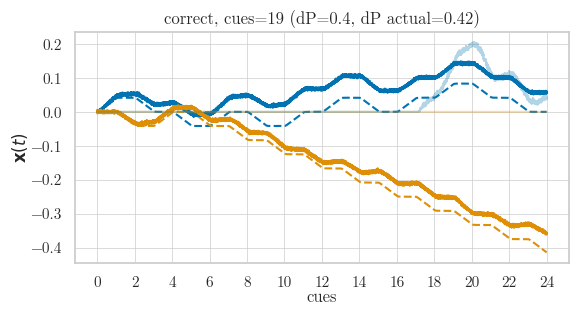

In [21]:
run_once(deltaP=0.4, maxSamples=12, seed=1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

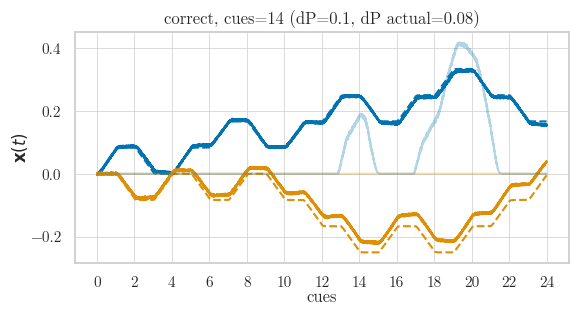

In [15]:
run_once(deltaP=0.1, maxSamples=12, seed=1)

In [30]:
def run_trials(nTrials, deltaP, maxSamples, seed, dt=0.001, **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    fig, axes = plt.subplots(nrows=nTrials, ncols=1, figsize=((6.38, 3*nTrials)), sharex=True, sharey=True)
    for n in range(nTrials):
        print(f"trial {n}")
        inputs.set_AB()
        net = build_network(inputs, seed=seed, **kwargs)
        sim = nengo.Simulator(net, progress_bar=False)
        with sim:
            sim.run(maxSamples, progress_bar=False)
        idealA = np.cumsum(sim.data[net.pAB][:,0]) * net.ramp_rate * dt
        idealB = np.cumsum(sim.data[net.pAB][:,1]) * net.ramp_rate * dt
        axes[n].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
        axes[n].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
        axes[n].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
        axes[n].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
        axes[n].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0])
        axes[n].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1])
        correct, cues, time = is_correct(inputs, net, sim)
        title = f"{'correct' if correct else 'incorrect'}, cues={cues:.0f} (dP={deltaP}, dP actual={inputs.dP_actual:.2f})"
        axes[n].set(xlabel="cues", ylabel=r"$\mathbf{x}(t)$", title=title,
           xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))

trial 0
trial 1
trial 2


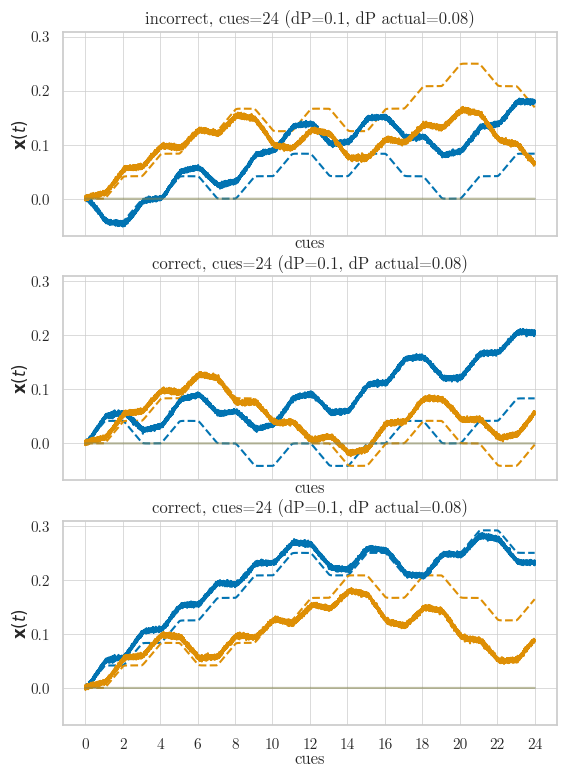

In [31]:
data = run_trials(nTrials=3, deltaP=0.1, maxSamples=12, seed=0, decision_threshold=0.5)

In [34]:
def run_selected(trials, deltaP, maxSamples, seed, dt=0.001, **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 5)), sharex=True)
    i = 0
    for n in range(np.max(trials)+1):
        inputs.set_AB()
        if n in trials:
            print(f"trial {n}")
            net = build_network(inputs, seed=seed, **kwargs)
            sim = nengo.Simulator(net, progress_bar=False)
            with sim:
                sim.run(maxSamples, progress_bar=False)
            idealA = np.cumsum(sim.data[net.pAB][:,0]) * net.ramp_rate * dt
            idealB = np.cumsum(sim.data[net.pAB][:,1]) * net.ramp_rate * dt
            axes[i].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
            axes[i].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
            axes[i].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
            axes[i].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
            axes[i].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0])
            axes[i].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1])
            axes[i].legend(loc='upper center', ncol=3)
            correct, cues, time = is_correct(inputs, net, sim)
            title = f"{'correct' if correct else 'incorrect'}, cues={cues:.0f} (dP={deltaP}, dP actual={inputs.dP_actual:.2f})"
            print(title)
            axes[i].set(ylabel=r"$\mathbf{x}(t)$",
                        yticks=((-0.4, -0.2, 0.0, 0.2, 0.4, 0.6)),
                        xticks=np.arange(0, maxSamples+1, 1),
                        xticklabels=np.arange(0, 2*maxSamples+2, 2))
            plt.tight_layout()
            i += 1
        axes[2].set(xlabel="cues")
        fig.savefig("dynamics_baseline.svg")
        fig.savefig("dynamics_baseline.png", dpi=600)


trial 2
correct, cues=24 (dP=0.2, dP actual=0.25)
trial 4
incorrect, cues=24 (dP=0.2, dP actual=0.17)
trial 8
correct, cues=24 (dP=0.2, dP actual=0.17)


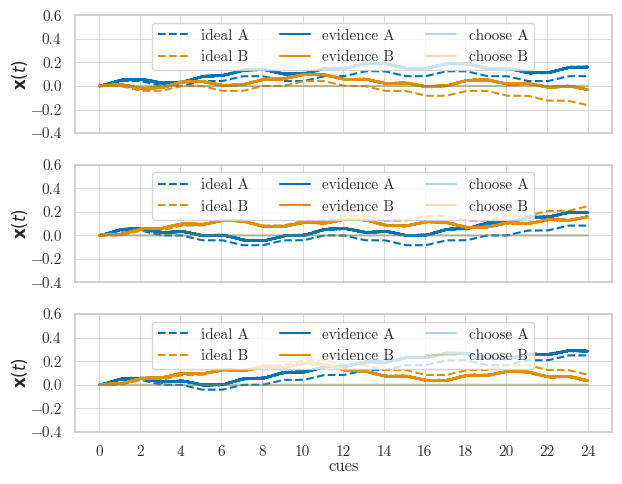

In [35]:
run_selected(trials=[2,4,8], deltaP=0.2, maxSamples=12, seed=0, decision_threshold=0.4)

In [36]:
def run_param_comparison(param, params, deltaP, maxSamples=12, seed=0,
        dt=0.001, ymin=0, ymax=0.6, plot_gate=False, plot_time=True, **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    inputs.set_AB()
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 5)), sharex=True)
    for i, p in enumerate(params):
        print(f"{param} = {p}")
        if param=="decision threshold":
            net = build_network(inputs, seed=seed, decision_threshold=p, **kwargs)
            title = "decision threshold"
            ylabel = r"$T="+str(p)+"$"
        if param=="ramp rate":
            net = build_network(inputs, seed=seed, w_ramp_rate=p, **kwargs)
            title = "ramp rate"
            ylabel = r"$w_{ramp}="+str(p)+"$"
        if param=="time elapsed":
            net = build_network(inputs, seed=seed, w_time_elapsed=p, **kwargs)
            title = "temporal urgency"
            ylabel = r"$w_{time}="+str(p)+"$"
        if param=="delta evidence":
            net = build_network(inputs, seed=seed, w_delta_evidence=p, **kwargs)
            title = "confidence"
            ylabel = r"$w_{delta}="+str(p)+"$"
        sim = nengo.Simulator(net, progress_bar=False)
        with sim:
            sim.run(maxSamples, progress_bar=False)
        idealA = np.cumsum(sim.data[net.pAB][:,0]) * net.ramp_rate * dt
        idealB = np.cumsum(sim.data[net.pAB][:,1]) * net.ramp_rate * dt
        axes[i].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
        axes[i].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
        axes[i].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
        axes[i].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
        axes[i].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0], zorder=0)
        axes[i].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1], zorder=0)
        correct, cues, time_choice = is_correct(inputs, net, sim)
        print(correct, cues, time_choice)
        if plot_gate:
            axes[i].plot(sim.trange(), sim.data[net.pGate], label='gate', color='k')
        if plot_time:
            axes[i].scatter(time_choice, 0.1, s=100, color='g' if correct else 'r', zorder=1)
        axes[i].set(ylabel=ylabel,
                    yticks=np.arange(ymin, ymax+0.1, 0.2), ylim=((ymin, ymax)),
                    xticks=np.arange(0, maxSamples+1, 1),
                    xticklabels=np.arange(0, 2*maxSamples+2, 2))
        plt.tight_layout()
        axes[0].set(title=title)
        axes[2].set(xlabel="cues")
        fig.savefig(f"dynamics_{param}.svg")
        fig.savefig(f"dynamics_{param}.png", dpi=600)

In [ ]:
run_param_comparison("ramp rate", [2,4,6], deltaP=0.2, seed=4, ymin=0, ymax=1)

ramp rate = 2
True 19 9.077
ramp rate = 4
True 14 6.703
ramp rate = 6


decision threshold = 0.5
decision threshold = 0.3
decision threshold = 0.2


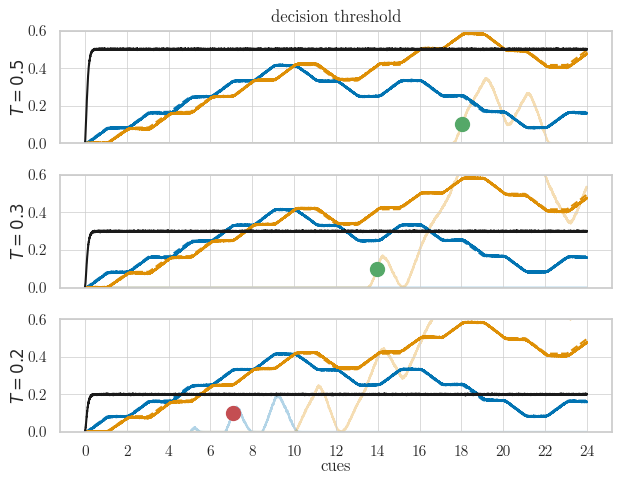

In [74]:
run_param_comparison("decision threshold", [0.5, 0.3, 0.2], deltaP=0.2, seed=4, plot_gate=True)

time elapsed = 0
time elapsed = 1
time elapsed = 2


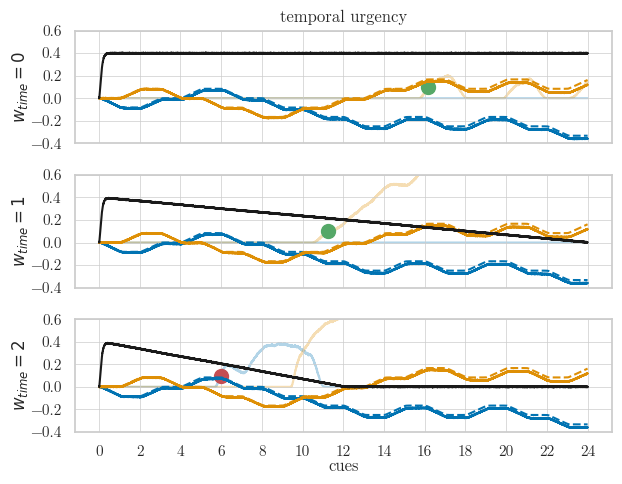

In [10]:
run_param_comparison("time elapsed", [0, 1, 2], deltaP=0.2, seed=100, plot_gate=True, ymin=-0.4, ymax=0.6)

delta evidence = 0
delta evidence = 0.5
delta evidence = 1.0


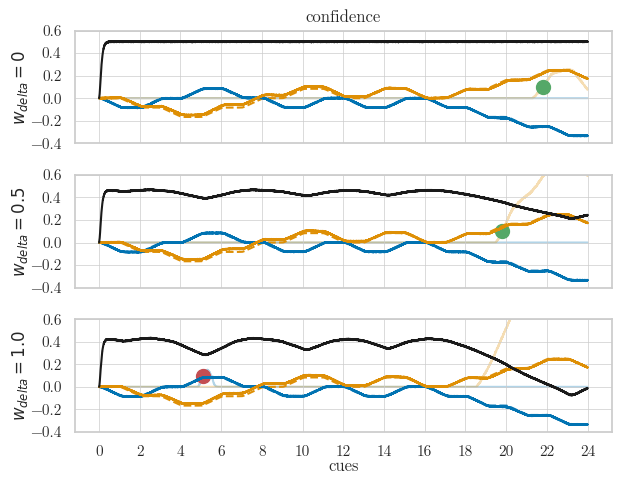

In [9]:
run_param_comparison("delta evidence", [0, 0.5, 1.0], deltaP=0.2, seed=180, plot_gate=True, ymin=-0.4, ymax=0.6, decision_threshold=0.5)

### find good seeds

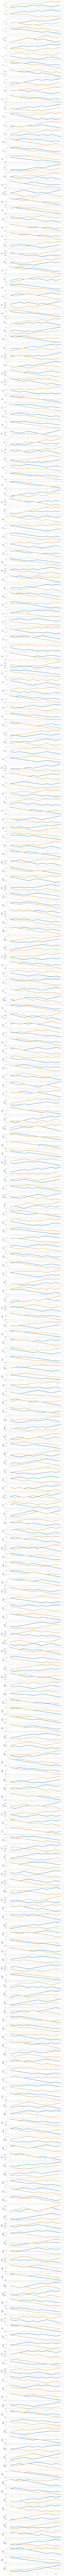

In [48]:
seeds = 300
fig, axes = plt.subplots(nrows=seeds, ncols=1, figsize=((6.38, seeds)), sharex=True)
for seed in range(seeds):
    inputs = Inputs(deltaP=0.2, maxSamples=12, seed=seed)
    inputs.set_AB()
    axes[seed].plot(np.cumsum(inputs.As), color=palette[0])
    axes[seed].plot(np.cumsum(inputs.Bs), color=palette[1])
    axes[seed].set(ylabel=seed)
plt.show()

# Scan parameters to study SAT

In [7]:
def scan_parameter(scan, nNetworks, nTrials, deltaPs, maxSamples=12, dt=0.001, low=0.1, high=0.3, load=False):
    if load:
        data = pd.read_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        collapsed_data = pd.read_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
    else:
        dfs = []
        columns = ('scan', 'param', 'seed', 'dP', 'trial', 'correct', 'cues')
        rng = np.random.RandomState(seed=nNetworks)
        params = np.linspace(low, high, nNetworks)
        for s in range(nNetworks):
            print(f"seed {s}")
            param = params[s]
            for dP in deltaPs:
                print(f"dP {dP}")
                inputs = Inputs(deltaP=dP, maxSamples=maxSamples, seed=s)
                for n in range(nTrials):
                    print(f"trial {n}")
                    inputs.set_AB()
                    if scan=="decision threshold":
                        net = build_network(inputs, seed=s, decision_threshold=param)
                    elif scan=="starting evidence":
                        net = build_network(inputs, seed=s, starting_evidence=param)
                    elif scan=="ramp rate":
                        net = build_network(inputs, seed=s, w_ramp_rate=param)
                    elif scan=="time elapsed":
                        net = build_network(inputs, seed=s, w_time_elapsed=param)
                    elif scan=="delta evidence":
                        net = build_network(inputs, seed=s, w_delta_evidence=param)
                    else:
                        raise
                    sim = nengo.Simulator(net, progress_bar=False)
                    with sim:
                        sim.run(maxSamples, progress_bar=False)
                    correct, cues, time = is_correct(inputs, net, sim)
                    dfs.append(pd.DataFrame([[scan, param, s, dP, n, correct, cues]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        print(data)
        # collapse data by individual  (take mean of cues and accuracy)
        dfs = []
        columns = ('scan', 'param', 'seed', 'dP', 'mean correct', 'mean cues')
        for s in range(data['seed'].max()+1):
            for dP in data['dP'].unique():
                d = data.query("seed==@s and dP==@dP")
                dfs.append(pd.DataFrame([[
                    scan, d['param'].mean(), s, np.around(d['dP'].mean(),2), d['correct'].mean(), d['cues'].mean()
                    ]], columns=columns))
        collapsed_data = pd.concat(dfs, ignore_index=True)
        collapsed_data.to_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
    return(collapsed_data)

### Scan Decision Threshold

In [ ]:
data = scan_parameter(scan="decision threshold", nNetworks=20, nTrials=20, deltaPs=[0.4, 0.2, 0.1], low=0.2, high=0.5)

seed 0
dP 0.4
trial 0
trial 1
trial 2
trial 3


In [ ]:
fig, ax = plt.subplots(figsize=((6.38, 3)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=ax, palette=palette)
ax.set(xlim=((0, 25)))
plt.show()

### Scan ramp rate

In [ ]:
data = scan_parameter(scan="ramp rate", nNetworks=20, nTrials=20, deltaPs=[0.4, 0.2, 0.1], low=1, high=3)

In [ ]:
fig, ax = plt.subplots(figsize=((6.38, 3)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=ax, palette=palette)
plt.show()

### Scan elapsed time

In [ ]:
data = scan_parameter(scan="time elapsed", nNetworks=20, nTrials=20, deltaPs=[0.4, 0.2, 0.1], low=0, high=1)

In [ ]:
fig, ax = plt.subplots(figsize=((6.38, 3)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=ax, palette=palette)
ax.set(xlim=((0, 25)))
plt.show()

### Scan delta evidence

In [ ]:
data = scan_parameter(scan="delta evidence", nNetworks=20, nTrials=20, deltaPs=[0.4, 0.2, 0.1], low=0, high=3)

In [ ]:
fig, ax = plt.subplots(figsize=((6.38, 3)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=ax, palette=palette)
ax.set(xlim=((0, 25)))
plt.show()

# Empirical Data

In [142]:
def format_empirical_data():
    data = pd.read_excel("empirical.xlsx", header=0)
    # remove test data, then remove redundant "tag" field
    for i, tag in enumerate(data['tag'].unique()):
        if type(tag)=='float':
            continue  # data wasn't label with tester tag
#         if type(tag)=='float' and np.isnan(tag):
#             data = data.drop(data[data.tag==tag].index)  # suspicious lack of tag
        if tag in ["Testversion", "TEST JOHANNES / LOL", "999", "Johannes Test 2"]:
            data = data.drop(data[data.tag==tag].index)
    data = data.drop(columns=['tag'])
    # rename sample_size to maxSamples
    data = data.rename(columns={'sample_size': 'maxSamples'})
    # rename ticks to cues
    data = data.rename(columns={'ticks': 'cues'})
    # add a "correct" column based on "selected right" and comparing "p1" to "p2"
    chosen_answer = data['selected_right'].to_numpy()
    correct_answer = data['p2'].to_numpy() > data['p1'].to_numpy()
    correct = chosen_answer == correct_answer
#     print(chosen_answer)
#     print(correct_answer)
#     print(correct, len(correct))
    data['correct'] = correct
    # add a column for the number of cues, for the selected option only, visible at the time of choice
    arg_right = np.where(chosen_answer==1)[0]
    arg_left = np.where(chosen_answer==0)[0]
    cues_chosen = chosen_answer  # 1 for right, 0 for left
    cues_chosen[arg_right] = data['last_right'].to_numpy()[arg_right]
    cues_chosen[arg_left] = data['last_left'].to_numpy()[arg_left]
    data['cues for chosen option'] = cues_chosen
    # remove remaining columns
    data = data.drop(columns=[
        'timestamp', 'subrange_key', 'duration_ms', 'empirical_delta', 'empirical_p1', 'empirical_p2',
        'selected_right', 'started_right', 'last_left', 'last_right', 'left', 'right'
    ])
    # first participant is fake
    data = data.drop(data[data.participant_id=="11e92cd2764348faa18918c94947d4fa"].index)
    data.to_pickle("empirical_data.pkl")

In [153]:
def collapse_empirical_data():
    data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12")
    dfs = []
    columns = ('ID', 'dP', 'mean correct', 'mean cues', 'mean cues for chosen option', 'trials')
    for s in data['participant_id'].unique():
        for dP in data['delta'].unique():
            d = data.query("participant_id==@s and delta==@dP")
            dfs.append(pd.DataFrame([[
                s, dP, d['correct'].mean(), d['cues'].mean(), d['cues for chosen option'].mean(), d['correct'].size,
                ]], columns=columns))
    collapsed_data = pd.concat(dfs, ignore_index=True)
    collapsed_data.to_pickle("collapsed_empirical_data.pkl")
    collapsed_data

In [154]:
format_empirical_data()
collapse_empirical_data()

In [155]:
empirical_data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12")

In [156]:
print(empirical_data)

                         participant_id  delta   p1   p2  maxSamples  cues  \
1      e00c31bc24424be5986b63504ef2572c    0.4  0.5  0.9          12    22   
3      e00c31bc24424be5986b63504ef2572c    0.4  0.5  0.1          12    21   
8      e00c31bc24424be5986b63504ef2572c    0.4  0.3  0.7          12     0   
10     e00c31bc24424be5986b63504ef2572c    0.1  0.3  0.4          12     1   
13     e00c31bc24424be5986b63504ef2572c    0.1  0.9  0.8          12    24   
...                                 ...    ...  ...  ...         ...   ...   
13389  a347f4a790a24f8fbcc5a41b458329cf    0.1  0.3  0.4          12    24   
13391  a347f4a790a24f8fbcc5a41b458329cf    0.1  0.8  0.7          12     7   
13393  a347f4a790a24f8fbcc5a41b458329cf    0.1  0.3  0.4          12    23   
13394  a347f4a790a24f8fbcc5a41b458329cf    0.2  0.3  0.5          12    10   
13398  a347f4a790a24f8fbcc5a41b458329cf    0.2  0.6  0.8          12    22   

       correct  cues for chosen option  
1         True        

In [157]:
collapsed_empirical_data = pd.read_pickle("collapsed_empirical_data.pkl")

In [158]:
print(collapsed_empirical_data)

                                   ID   dP  mean correct  mean cues  \
0    e00c31bc24424be5986b63504ef2572c  0.4      0.916667  18.416667   
1    e00c31bc24424be5986b63504ef2572c  0.1      0.846154  21.692308   
2    e00c31bc24424be5986b63504ef2572c  0.2      1.000000  19.615385   
3    58c54d6d2775404a9c3a3cde65c32a71  0.4      0.895833   7.916667   
4    58c54d6d2775404a9c3a3cde65c32a71  0.1      0.666667   9.020833   
..                                ...  ...           ...        ...   
166  12d8da1d3ca84c3899edc82bad99fc23  0.1      0.805556  12.916667   
167  12d8da1d3ca84c3899edc82bad99fc23  0.2      0.972973  12.189189   
168  a347f4a790a24f8fbcc5a41b458329cf  0.4      1.000000  12.333333   
169  a347f4a790a24f8fbcc5a41b458329cf  0.1      0.703704  18.481481   
170  a347f4a790a24f8fbcc5a41b458329cf  0.2      0.962963  13.518519   

     mean cues for chosen option  trials  
0                       8.833333      12  
1                      10.384615      13  
2                 

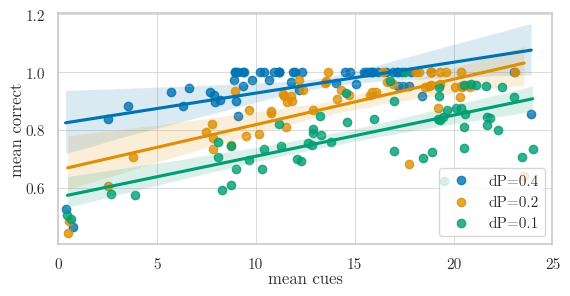

In [186]:
fig, ax = plt.subplots(figsize=((6.38, 3)))
sns.regplot(data=collapsed_empirical_data.query("dP==0.4"), x="mean cues", y="mean correct", ax=ax, color=palette[0], label="dP=0.4")
sns.regplot(data=collapsed_empirical_data.query("dP==0.2"), x="mean cues", y="mean correct", ax=ax, color=palette[1], label="dP=0.2")
sns.regplot(data=collapsed_empirical_data.query("dP==0.1"), x="mean cues", y="mean correct", ax=ax, color=palette[2], label="dP=0.1")
ax.set(xlim=((0, 25)))
ax.legend(loc='lower right')
plt.show()